# Bank Marketing Campaign - Opening a Term Deposit

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc
from sklearn import tree

from matplotlib.ticker import FuncFormatter

from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
import plotly.graph_objs as go

import chart_studio.plotly as py

from imblearn.over_sampling import SMOTE

## Loading dataset

In [3]:
df = pd.read_csv('bank-full.csv', sep=';')

print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [ ]:
df.columns

In [ ]:
print("printing basic data:\n", df.describe())
print("\nchecking if data is null:\n", df.isnull().sum())

In [ ]:
print("Num of term subscriptions")
df['y'].value_counts()

In [ ]:
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

train_data, temp_data = train_test_split(df, test_size=(1 - train_percentage), random_state=42)
val_test_percentage = val_percentage / (val_percentage + test_percentage)
val_data, test_data = train_test_split(temp_data, test_size=val_test_percentage, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Validation set size: {len(val_data)}")

## Exploratory Data Analysis

### Information on Term Subscriptions

In [ ]:
colors = ["#3399ff", "#ffa500"]
palette = ["#3399ff", "#ffa500"]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('Information on Term Subscriptions', fontsize=20)

df["y"].value_counts().plot.pie(
    explode=[0, 0.25],
    autopct='%1.2f%%',
    ax=ax[0],
    shadow=True,
    colors=colors,
    fontsize=12,
    startangle=25
)
ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

sns.barplot(
    x="education",
    y="balance",
    hue="y",
    data=df,
    palette=palette,
    estimator=lambda x: len(x) / len(df) * 100,
    ax=ax[1]
)
ax[1].set_ylabel("(%)")
education_labels = df["education"].unique()
ax[1].set_xticks(range(len(education_labels)))
ax[1].set_xticklabels(education_labels, rotation=0, rotation_mode="anchor")

plt.show()

### Numeric data distribution

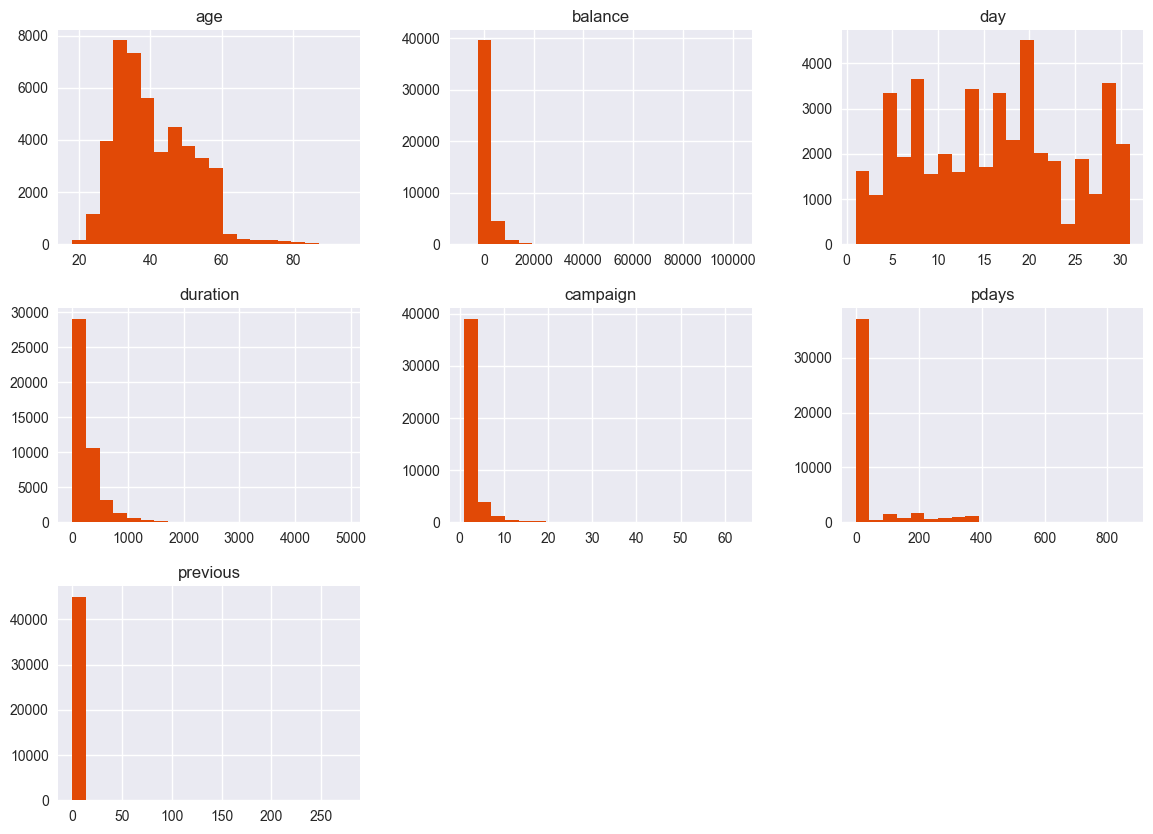

In [4]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

df.hist(bins=20, figsize=(14,10), color='#E14906')
plt.show()

In [ ]:
fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

g = sns.boxplot(x="default", y="balance", hue="y", data=df, palette="muted", ax=ax1)
g.set_title("Amount of Balance by Term Subscriptions")

g1 = sns.boxplot(x="job", y="balance", hue="y", data=df, palette="RdBu_r", ax=ax2)
job_labels = df["job"].unique()
job_positions = range(len(job_labels))
g1.set_xticks(job_positions)
g1.set_xticklabels(job_labels, rotation=90, rotation_mode="anchor")
g1.set_title("Type of Work by Term Subscriptions")

g2 = sns.violinplot(data=df, x="education", y="balance", hue="y", palette="RdBu_r", ax=ax3)
g2.set_title("Distribution of Balance by Education")

plt.show()

### Number of Ocupations

In [ ]:
import squarify
import random

df = df.drop(df.loc[df["balance"] == 0].index)

x = 0
y = 0
width = 100
height = 100

job_names = df['job'].value_counts().index
values = df['job'].value_counts().tolist()

normed = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(normed, x, y, width, height)

colors = ['rgb(200, 255, 144)','rgb(135, 206, 235)',
          'rgb(235, 164, 135)','rgb(220, 208, 255)',
          'rgb(253, 253, 150)','rgb(255, 127, 80)', 
          'rgb(218, 156, 133)', 'rgb(245, 92, 76)',
          'rgb(252, 64, 68)', 'rgb(154, 123, 91)']

random.shuffle(colors)

shapes = []
annotations = []
counter = 0

for r in rects:
    shapes.append(
        dict(
            type = 'rect',
            x0 = r['x'],
            y0 = r['y'],
            x1 = r['x'] + r['dx'],
            y1 = r['y'] + r['dy'],
            line = dict(width=2),
            fillcolor = colors[counter]
        )
    )
    annotations.append(
        dict(
            x = r['x']+(r['dx']/2),
            y = r['y']+(r['dy']/2),
            text = values[counter],
            showarrow = False
        )
    )
    counter = counter + 1
    if counter >= len(colors):
        counter = 0
    
# For hover text
trace0 = go.Scatter(
    x = [ r['x']+(r['dx']/2) for r in rects],
    y = [ r['y']+(r['dy']/2) for r in rects],
    text = [ str(v) for v in job_names],
    mode='text',
)

layout = dict(
    title='Number of Occupations',
    height=700, 
    width=700,
    xaxis=dict(showgrid=False,zeroline=False),
    yaxis=dict(showgrid=False,zeroline=False),
    shapes=shapes,
    annotations=annotations,
    hovermode='closest'
)

# With hovertext
figure = dict(data=[trace0], layout=layout)

iplot(figure, filename='squarify-treemap')

### Distribution of Ages by Occupation

In [ ]:
suscribed_df = df.loc[df["y"] == "yes"]

occupations = df["job"].unique().tolist()

# Get the balances by jobs
management = suscribed_df["age"].loc[suscribed_df["job"] == "management"].values
technician = suscribed_df["age"].loc[suscribed_df["job"] == "technician"].values
services = suscribed_df["age"].loc[suscribed_df["job"] == "services"].values
retired = suscribed_df["age"].loc[suscribed_df["job"] == "retired"].values
blue_collar = suscribed_df["age"].loc[suscribed_df["job"] == "blue-collar"].values
unemployed = suscribed_df["age"].loc[suscribed_df["job"] == "unemployed"].values
entrepreneur = suscribed_df["age"].loc[suscribed_df["job"] == "entrepreneur"].values
housemaid = suscribed_df["age"].loc[suscribed_df["job"] == "housemaid"].values
self_employed = suscribed_df["age"].loc[suscribed_df["job"] == "self-employed"].values
student = suscribed_df["age"].loc[suscribed_df["job"] == "student"].values


ages = [management, technician, services, retired, blue_collar, unemployed, 
         entrepreneur, housemaid, self_employed, student]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)',
          'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)',
         'rgba(229, 126, 56, 0.5)', 'rgba(229, 56, 56, 0.5)',
         'rgba(174, 229, 56, 0.5)', 'rgba(229, 56, 56, 0.5)']

traces = []

for xd, yd, cls in zip(occupations, ages, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Distribution of Ages by Occupation',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(224,255,246)',
    plot_bgcolor='rgb(251,251,251)',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

### Marital status comparison

In [ ]:
fig = ff.create_facet_grid(
    df,
    x='duration',
    y='balance',
    color_name='marital',
    show_boxes=False,
    marker={'size': 10, 'opacity': 1.0},
    colormap={'single': 'rgb(165, 242, 242)', 'married': 'rgb(253, 174, 216)', 'divorced': 'rgba(201, 109, 59, 0.82)'}
)

iplot(fig, filename='facet - custom colormap')

### Facet gird of Martial status

In [ ]:
fig = ff.create_facet_grid(
    df,
    y='balance',
    facet_row='marital',
    facet_col='y',
    trace_type='box',
)

iplot(fig, filename='facet - box traces')

### The Impact of Duration in Opening a Term Deposit

In [ ]:
sns.set_style('whitegrid')

def percent(x, pos):
    return '%1.0f%%' % x

avg_duration = df['duration'].mean()

df["duration_status"] = np.nan
df["duration_status"] = df["duration_status"].astype(object)

lst = [df]

for col in lst:
    col.loc[col["duration"] < avg_duration, "duration_status"] = "below_average"
    col.loc[col["duration"] > avg_duration, "duration_status"] = "above_average"

pct_term = pd.crosstab(df['duration_status'], df['y']).apply(lambda r: round(r/r.sum(), 2) * 100, axis=1)

ax = pct_term.plot(kind='bar', stacked=False, cmap='RdBu')
plt.title("The Impact of Duration \n in Opening a Term Deposit", fontsize=18)
plt.xlabel("Duration Status", fontsize=18)
plt.ylabel("Percentage (%)", fontsize=18)
ax.yaxis.set_major_formatter(FuncFormatter(percent))

i = 0
for p in ax.patches:
    height_adjustment = 1.02
    if i >= 2:
        height_adjustment = 1.1
    ax.annotate(f'{p.get_height():.0f}%',
                (p.get_x() + p.get_width() / 2., p.get_height() * height_adjustment),
                ha='center', va='center')
    i = i + 1

plt.show()

### Correlation Matrix

In [ ]:
fig = plt.figure(figsize=(12,8))
df['y'] = LabelEncoder().fit_transform(df['y'])

numeric_df = df.select_dtypes(exclude="object")

corr_numeric = numeric_df.corr()

sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

### Pair Plot

In [ ]:
sns.pairplot(df, hue='y')
plt.show()

## Removing Outliers

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000

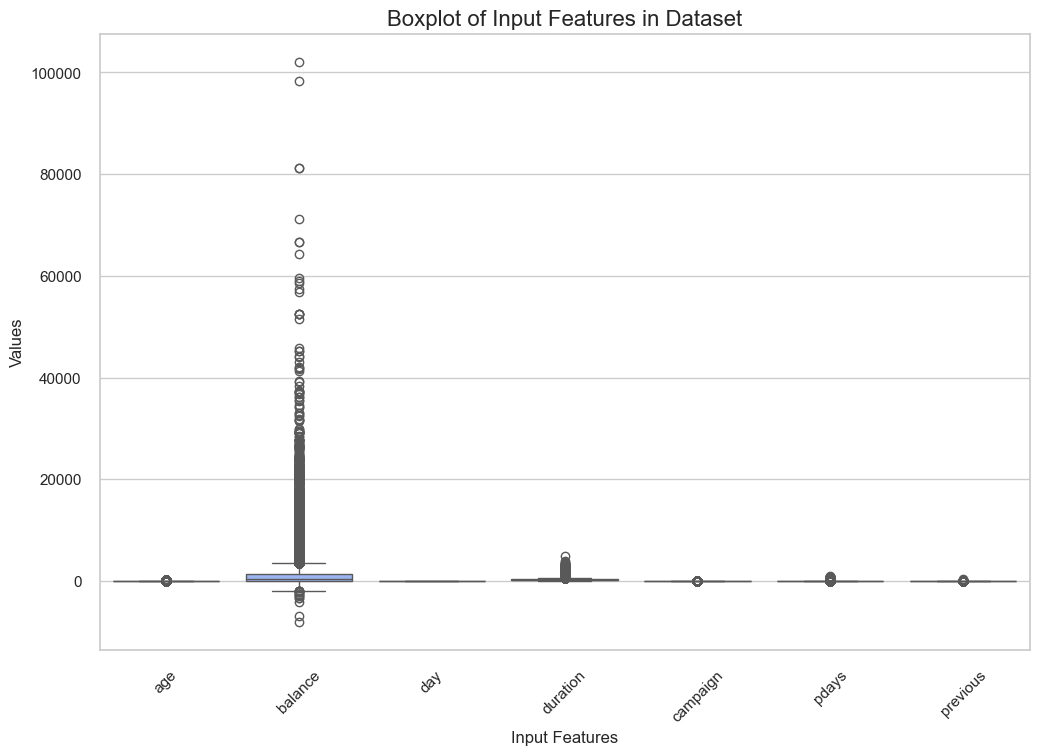

       age           job  marital  education default  balance housing loan  \
0       58    management  married   tertiary      no     2143     yes   no   
1       44    technician   single  secondary      no       29     yes   no   
2       33  entrepreneur  married  secondary      no        2     yes  yes   
3       47   blue-collar  married    unknown      no     1506     yes   no   
4       33       unknown   single    unknown      no        1      no   no   
...    ...           ...      ...        ...     ...      ...     ...  ...   
45198   37    management  married   tertiary      no     1428      no   no   
45202   34        admin.   single  secondary      no      557      no   no   
45203   23       student   single   tertiary      no      113      no   no   
45205   25    technician   single  secondary      no      505      no  yes   
45209   57   blue-collar  married  secondary      no      668      no   no   

         contact  day month  duration  campaign  pdays  previou

In [10]:
df = pd.read_csv('bank-full.csv', delimiter=';')

print(df.head())

print(df.describe())

numeric_cols = df.select_dtypes(include=['number']).columns

print(numeric_cols)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numeric_cols], palette="coolwarm")
plt.title('Boxplot of Input Features in Dataset', fontsize=16)
plt.xlabel('Input Features', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = (df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))

df_cleaned = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(df_cleaned)

df_cleaned.to_csv('bank-full-cleaned.csv', index=False, sep=';')

### Logical Regression Classifier with cleaned dataset

In [5]:
lr_df = pd.read_csv('bank-full-cleaned.csv', sep=';')

categorical_columns = lr_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    lr_df[column] = le.fit_transform(lr_df[column])
    label_encoders[column] = le

X = lr_df.drop('y', axis=1)
y = lr_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', C=1.0)
time_start = time.time()
lr.fit(X_train, y_train)
time_end = time.time()
lr_time = time_end - time_start

y_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred)
lr_recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * lr_accuracy))
print("Precision score: {:.2f}%".format(100 * lr_precision))
print("Recall score: {:.2f}%".format(100 * lr_recall))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      5331
           1       0.37      0.06      0.11       308

    accuracy                           0.94      5639
   macro avg       0.66      0.53      0.54      5639
weighted avg       0.92      0.94      0.92      5639

Accuracy score: 94.31%
Precision score: 37.25%
Recall score: 6.17%


In [6]:
lr_train_score = lr.score(X_train, y_train)

print(f"Training Score for Logistic Regression: {lr_train_score:.4f}")
print(f"Training Time for Logistic Regression: {lr_time:.2f} s")

log_scores = cross_val_score(lr, X_train, y_train, cv=3)
lr_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Logistic Regression: {lr_log_reg_mean:.4f}")

Training Score for Logistic Regression: 0.9420
Training Time for Logistic Regression: 0.18 s
Crossval Mean Score for Logistic Regression: 0.9418


#### Confusion Matrix for Logistic Regression Model

Confusion Matrix:
[[5299   32]
 [ 289   19]]


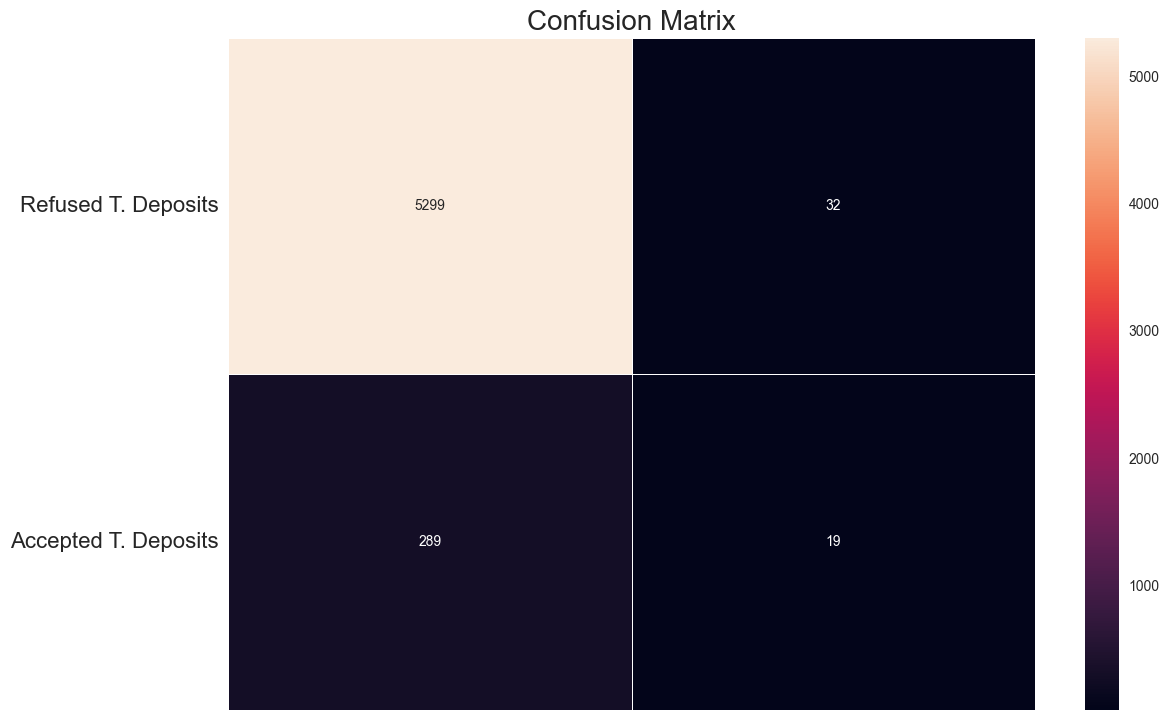

In [7]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)

print(f"Confusion Matrix:\n{conf_matrix}")

#### ROC Curve for Logistic Regression Model

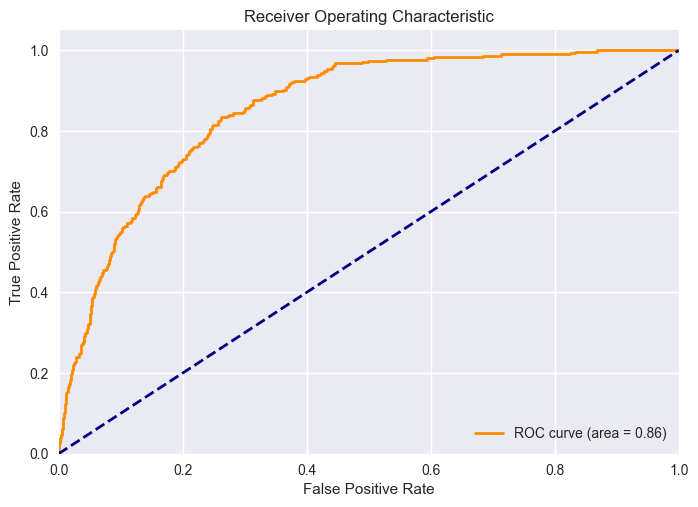

In [8]:
y_pred_proba = lr.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Precision-Recall Curve for Logistic Regression

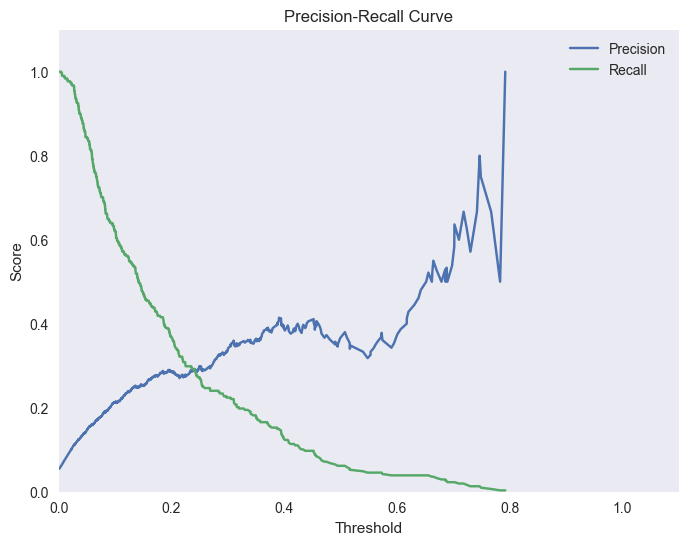

Best Threshold: 0.14
Best F1 Score: 0.34


In [9]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.legend()
plt.grid()
plt.show()

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Best F1 Score: {f1_scores[best_threshold_index]:.2f}')

## Training Models

### Logical Regression Classifier

In [ ]:
lr_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = lr_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    lr_df[column] = le.fit_transform(lr_df[column])
    label_encoders[column] = le

X = lr_df.drop('y', axis=1)
y = lr_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', C=1.0)
time_start = time.time()
lr.fit(X_train, y_train)
time_end = time.time()
lr_time = time_end - time_start

y_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred)
lr_recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * lr_accuracy))
print("Precision score: {:.2f}%".format(100 * lr_precision))
print("Recall score: {:.2f}%".format(100 * lr_recall))

In [ ]:
lr_train_score = lr.score(X_train, y_train)

print(f"Training Score for Logistic Regression: {lr_train_score:.4f}")
print(f"Training Time for Logistic Regression: {lr_time:.2f} s")

log_scores = cross_val_score(lr, X_train, y_train, cv=3)
lr_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Logistic Regression: {lr_log_reg_mean:.4f}")

#### Confusion Matrix for Logistic Regression Model

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)

print(f"Confusion Matrix:\n{conf_matrix}")

#### ROC Curve for Logistic Regression Model

In [ ]:
y_pred_proba = lr.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Precision-Recall Curve for Logistic Regression

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.legend()
plt.grid()
plt.show()

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Best F1 Score: {f1_scores[best_threshold_index]:.2f}')

### Decision Tree Classifier

In [ ]:
dt_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = dt_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    dt_df[column] = le.fit_transform(dt_df[column])
    label_encoders[column] = le

X = dt_df.drop('y', axis=1)
y = dt_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01
)
time_start = time.time()
dt.fit(X_train, y_train)
time_end = time.time()
dt_time = time_end - time_start

y_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * dt_accuracy))
print("Precision score: {:.2f}%".format(100 * dt_precision))
print("Recall score: {:.2f}%".format(100 * dt_recall))

In [ ]:
dt_train_score = dt.score(X_train, y_train)

print(f"Training Score for Decision Tree: {dt_train_score:.4f}")
print(f"Training Time for Decision Tree: {dt_time:.2f} s")

log_scores = cross_val_score(dt, X_train, y_train, cv=3)
dt_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Decision Tree: {dt_log_reg_mean:.4f}")

#### Confusion Matrix for Decision Tree

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)

print(f"Confusion Matrix:\n{conf_matrix}")

#### ROC Curve for Decision Tree

In [ ]:
y_pred_proba = dt.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Precision-Recall Curve for Decision Tree

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.grid()
plt.show()

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Best F1 Score: {f1_scores[best_threshold_index]:.2f}')

#### Generated Decision Tree

In [ ]:
#plt.figure(figsize=(20, 10))
#tree.plot_tree(dt, feature_names=X.columns, class_names=['no', 'yes'], filled=True)
#plt.title('Decision Tree for Bank Marketing Campaign')
#plt.show()

#### Finding importance rate of each feature in Decision Tree

In [ ]:
term_deposits = df.copy()

term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

target_name = 'y'
X = term_deposits.drop('y', axis=1)

label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

tree = DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01
)

tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('y', axis=1).columns
indices = np.argsort(importances)[::-1]

print("Feature importance ranking:")

for f in range(X_train.shape[1]):
    print("%d. Feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with Decision Tree Classifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

### GradientBoosting Classifier

In [ ]:
gb_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = gb_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    gb_df[column] = le.fit_transform(gb_df[column])
    label_encoders[column] = le

X = gb_df.drop('y', axis=1)
y = gb_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb = GradientBoostingClassifier(random_state=42)
time_start = time.time()
gb.fit(X_train, y_train)
time_end = time.time()
gb_time = time_end - time_start

y_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred)
gb_precision = precision_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * gb_accuracy))
print("Precision score: {:.2f}%".format(100 * gb_precision))
print("Recall score: {:.2f}%".format(100 * gb_recall))

In [ ]:
gb_train_score = gb.score(X_train, y_train)

print(f"Training Score for Gradient Boosting: {gb_train_score:.4f}")
print(f"Training Time for Gradient Boosting: {gb_time:.2f} s")

log_scores = cross_val_score(gb, X_train, y_train, cv=3)
gb_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Gradient Boosting: {gb_log_reg_mean:.4f}")

#### Confusion Matrix for Gradient Boosting

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)

print(f"Confusion Matrix:\n{conf_matrix}")

#### ROC Curve for Gradient Boosting

In [ ]:
y_pred_proba = gb.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Precision-Recall Curve for Gradient Boosting

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.legend()
plt.grid()
plt.show()

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Best F1 Score: {f1_scores[best_threshold_index]:.2f}')


### Classifiers comparison

In [ ]:
models              = ['Logical Regression', 'Decision Tree', 'Gradient Boosting']
accuracy            = [lr_accuracy * 100, dt_accuracy * 100, gb_accuracy * 100]
precision           = [lr_precision * 100, dt_precision * 100, gb_precision * 100]
recall              = [lr_recall * 100, dt_recall * 100, gb_recall * 100]
train_score         = [lr_train_score * 100, dt_train_score * 100, gb_train_score * 100]
train_time          = [lr_time, dt_time, gb_time]
crossval_mean_score = [lr_log_reg_mean, dt_log_reg_mean, gb_log_reg_mean]

def percent(x, pos):
    return '%1.0f%%' % x

def seconds(x, pos):
    return '%1.1f s' % x

fig, axs = plt.subplots(3, 2, figsize=(14, 10))

axs[0, 0].bar(models, accuracy, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Accuracy percent')
axs[0, 0].set_ylim(0, 100)
axs[0, 0].yaxis.set_major_formatter(FuncFormatter(percent))

axs[0, 1].bar(models, precision, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Precision percent')
axs[0, 1].set_ylim(0, 100)
axs[0, 1].yaxis.set_major_formatter(FuncFormatter(percent))

axs[1, 0].bar(models, recall, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Recall percent')
axs[1, 0].set_ylim(0, 100)
axs[1, 0].yaxis.set_major_formatter(FuncFormatter(percent))

axs[1, 1].bar(models, train_score, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[1, 1].set_title('Train Score')
axs[1, 1].set_ylabel('Train Score')
axs[1, 1].set_ylim(0, 100)
axs[1, 1].yaxis.set_major_formatter(FuncFormatter(percent))

axs[2, 0].bar(models, train_time, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[2, 0].set_title('Train Time')
axs[2, 0].set_ylabel('Train Time')
axs[2, 0].set_ylim(0, max(train_time) + 0.1)
axs[2, 0].yaxis.set_major_formatter(FuncFormatter(seconds))

axs[2, 1].bar(models, crossval_mean_score, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[2, 1].set_title('Crossval Mean Score')
axs[2, 1].set_ylabel('Score')
axs[2, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Training Models with SMOTE (oversampling)

### Logistic Regression

In [ ]:
lr_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = lr_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    lr_df[column] = le.fit_transform(lr_df[column])
    label_encoders[column] = le

X = lr_df.drop('y', axis=1)
y = lr_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

lr = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', C=1.0)
time_start = time.time()
lr.fit(X_train_res, y_train_res)
time_end = time.time()
smote_lr_time = time_end - time_start

y_pred_prob = lr.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.legend()
plt.grid()
plt.show()

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Best F1 Score: {f1_scores[best_threshold_index]:.2f}')

y_pred = (y_pred_prob >= best_threshold).astype(int)

smote_lr_accuracy = accuracy_score(y_test, y_pred)
smote_lr_precision = precision_score(y_test, y_pred)
smote_lr_recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * smote_lr_accuracy))
print("Precision score: {:.2f}%".format(100 * smote_lr_precision))
print("Recall score: {:.2f}%".format(100 * smote_lr_recall))

In [ ]:
smote_lr_train_score = lr.score(X_train, y_train)

print(f"Training Score for Logistic Regression with SMOTE: {smote_lr_train_score:.4f}")
print(f"Training Time for Logistic Regression with SMOTE: {smote_lr_time:.2f} s")

log_scores = cross_val_score(lr, X_train, y_train, cv=3)
smote_lr_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Logistic Regression with SMOTE: {smote_lr_log_reg_mean:.4f}")

### Decision Tree

In [ ]:
dt_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = dt_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    dt_df[column] = le.fit_transform(dt_df[column])
    label_encoders[column] = le

X = dt_df.drop('y', axis=1)
y = dt_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

dt = DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01
)
time_start = time.time()
dt.fit(X_train_res, y_train_res)
time_end = time.time()
smote_dt_time = time_end - time_start

y_pred_prob = dt.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.legend()
plt.grid()
plt.show()

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Best F1 Score: {f1_scores[best_threshold_index]:.2f}')

y_pred = (y_pred_prob >= best_threshold).astype(int)

smote_dt_accuracy = accuracy_score(y_test, y_pred)
smote_dt_precision = precision_score(y_test, y_pred)
smote_dt_recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * smote_dt_accuracy))
print("Precision score: {:.2f}%".format(100 * smote_dt_precision))
print("Recall score: {:.2f}%".format(100 * smote_dt_recall))

In [ ]:
smote_dt_train_score = dt.score(X_train, y_train)

print(f"Training Score for Decision Tree with SMOTE: {smote_dt_train_score:.4f}")
print(f"Training Time for Decision Tree with SMOTE: {smote_dt_time:.2f} s")

log_scores = cross_val_score(dt, X_train, y_train, cv=3)
smote_dt_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Decision Tree with SMOTE: {smote_dt_log_reg_mean:.4f}")

### Gradient Boosting

In [ ]:
gb_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = gb_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    gb_df[column] = le.fit_transform(gb_df[column])
    label_encoders[column] = le

X = gb_df.drop('y', axis=1)
y = gb_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

gb = GradientBoostingClassifier(random_state=42)
time_start = time.time()
gb.fit(X_train_res, y_train_res)
time_end = time.time()
smote_gb_time = time_end - time_start

y_pred_prob = gb.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.legend()
plt.grid()
plt.show()

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Best F1 Score: {f1_scores[best_threshold_index]:.2f}')

y_pred = (y_pred_prob >= best_threshold).astype(int)

smote_gb_accuracy = accuracy_score(y_test, y_pred)
smote_gb_precision = precision_score(y_test, y_pred)
smote_gb_recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * smote_gb_accuracy))
print("Precision score: {:.2f}%".format(100 * smote_gb_precision))
print("Recall score: {:.2f}%".format(100 * smote_gb_recall))

In [ ]:
smote_gb_train_score = gb.score(X_train, y_train)

print(f"Training Score for Gradient Boosting with SMOTE: {smote_gb_train_score:.4f}")
print(f"Training Time for Gradient Boosting with SMOTE: {smote_gb_time:.2f} s")

log_scores = cross_val_score(gb, X_train, y_train, cv=3)
smote_gb_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Gradient Boosting with SMOTE: {smote_gb_log_reg_mean:.4f}")

### Classifiers Comparison with SMOTE

In [ ]:
models                    = ['Logical Regression', 'Decision Tree', 'Gradient Boosting']
smote_accuracy            = [smote_lr_accuracy * 100, smote_dt_accuracy * 100, smote_gb_accuracy * 100]
smote_precision           = [smote_lr_precision * 100, smote_dt_precision * 100, smote_gb_precision * 100]
smote_recall              = [smote_lr_recall * 100, smote_dt_recall * 100, smote_gb_recall * 100]
smote_train_score         = [smote_lr_train_score * 100, smote_dt_train_score * 100, smote_gb_train_score * 100]
smote_train_time          = [smote_lr_time, smote_dt_time, smote_gb_time]
smote_crossval_mean_score = [smote_lr_log_reg_mean, smote_dt_log_reg_mean, smote_gb_log_reg_mean]

def percent(x, pos):
    return '%1.0f%%' % x

def seconds(x, pos):
    return '%1.1f s' % x

fig, axs = plt.subplots(3, 2, figsize=(14, 10))

axs[0, 0].bar(models, smote_accuracy, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Percent')
axs[0, 0].set_ylim(0, 100)
axs[0, 0].yaxis.set_major_formatter(FuncFormatter(percent))

axs[0, 1].bar(models, smote_precision, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Percent')
axs[0, 1].set_ylim(0, 100)
axs[0, 1].yaxis.set_major_formatter(FuncFormatter(percent))

axs[1, 0].bar(models, smote_recall, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Percent')
axs[1, 0].set_ylim(0, 100)
axs[1, 0].yaxis.set_major_formatter(FuncFormatter(percent))

axs[1, 1].bar(models, smote_train_score, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[1, 1].set_title('Train Score')
axs[1, 1].set_ylabel('Percent')
axs[1, 1].set_ylim(0, 100)
axs[1, 1].yaxis.set_major_formatter(FuncFormatter(percent))

axs[2, 0].bar(models, smote_train_time, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[2, 0].set_title('Train Time')
axs[2, 0].set_ylabel('Time')
axs[2, 0].set_ylim(0, max(train_time) + 1)
axs[2, 0].yaxis.set_major_formatter(FuncFormatter(seconds))

axs[2, 1].bar(models, smote_crossval_mean_score, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[2, 1].set_title('Crossval Mean Score')
axs[2, 1].set_ylabel('Score')
axs[2, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Global Model comparison with and without SMOTE

In [ ]:
models = ['Logical Regression', 'Decision Tree', 'Gradient Boosting']
x = np.arange(len(models))
width = 0.35  

fig, axs = plt.subplots(3, 2, figsize=(18, 18))

axs[0, 0].bar(x - width/2, accuracy, width, label='without SMOTE', color='royalblue')
axs[0, 0].bar(x + width/2, smote_accuracy, width, label='with SMOTE', color='darkorange')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Percent')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(models)
axs[0, 0].set_ylim(0, 100)
axs[0, 0].yaxis.set_major_formatter(FuncFormatter(percent))
axs[0, 0].legend()

axs[0, 1].bar(x - width/2, precision, width, label='without SMOTE', color='royalblue')
axs[0, 1].bar(x + width/2, smote_precision, width, label='with SMOTE', color='darkorange')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Percent')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(models)
axs[0, 1].set_ylim(0, 100)
axs[0, 1].yaxis.set_major_formatter(FuncFormatter(percent))
axs[0, 1].legend()

axs[1, 0].bar(x - width/2, recall, width, label='without SMOTE', color='royalblue')
axs[1, 0].bar(x + width/2, smote_recall, width, label='with SMOTE', color='darkorange')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Percent')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(models)
axs[1, 0].set_ylim(0, 100)
axs[1, 0].yaxis.set_major_formatter(FuncFormatter(percent))
axs[1, 0].legend()

axs[1, 1].bar(x - width/2, train_score, width, label='without SMOTE', color='royalblue')
axs[1, 1].bar(x + width/2, smote_train_score, width, label='with SMOTE', color='darkorange')
axs[1, 1].set_title('Train Score')
axs[1, 1].set_ylabel('Percent')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(models)
axs[1, 1].set_ylim(0, 100)
axs[1, 1].yaxis.set_major_formatter(FuncFormatter(percent))
axs[1, 1].legend()

axs[2, 0].bar(x - width/2, train_time, width, label='without SMOTE', color='royalblue')
axs[2, 0].bar(x + width/2, smote_train_time, width, label='with SMOTE', color='darkorange')
axs[2, 0].set_title('Train Time')
axs[2, 0].set_ylabel('Time (s)')
axs[2, 0].set_xticks(x)
axs[2, 0].set_xticklabels(models)
axs[2, 0].set_ylim(0, max(max(train_time), max(smote_train_time)) + 0.1)
axs[2, 0].yaxis.set_major_formatter(FuncFormatter(seconds))
axs[2, 0].legend()

axs[2, 1].bar(x - width/2, crossval_mean_score, width, label='without SMOTE', color='royalblue')
axs[2, 1].bar(x + width/2, smote_crossval_mean_score, width, label='with SMOTE', color='darkorange')
axs[2, 1].set_title('Crossval Mean Score')
axs[2, 1].set_ylabel('Score')
axs[2, 1].set_xticks(x)
axs[2, 1].set_xticklabels(models)
axs[2, 1].set_ylim(0, 1)
axs[2, 1].legend()

plt.tight_layout()
plt.show()

## Classification Model

In [ ]:
term_deposits = df.copy()
dep = term_deposits['y']
term_deposits.drop(labels=['y'], axis=1,inplace=True)
term_deposits.insert(0, 'y', dep)
term_deposits.head()

term_deposits["housing"].value_counts()/len(term_deposits)

In [ ]:
term_deposits["loan"].value_counts() / len(term_deposits)

## Optimization of hyperparameters

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print("Best param:", clf.best_params_)
